In [2]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
from scipy.stats import binned_statistic
import warnings
from soilgasflux_fcs import pareto
warnings.filterwarnings("ignore")

In [15]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data_v4/')

test_number = 6
normalizationType = 'no' #['no', 'len', 'yRange']
# add_info = '_ln_v2test4' #['', '_ln_v2', '_ln_v2test0]
add_info = '_test5'

filename_regular = f'test{test_number:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_mc = f'test{test_number:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_expected = f'expected_test{test_number:02}_2025-05-08.nc'
print(filename_regular)
print(filename_mc)
print(filename_expected)

ds = xr.open_dataset(processed_data_path / filename_regular)
dsMC = xr.open_dataset(processed_data_path / filename_mc)
expected_ds = xr.open_dataset(processed_data_path / filename_expected)

test06_noNorm_test5_2025-05-08.nc
test06_MC_noNorm_test5_2025-05-08.nc
expected_test06_2025-05-08.nc


In [16]:
test_a = expected_ds.isel(cutoff=0)['dcdt(HM)'].values
binned_statistic(test_a, test_a, bins=3)[2]
# Define your intensity categories
intensity_labels = ['low', 'medium', 'high']

# Calculate bin indices (0, 1, or 2)
bin_indices = binned_statistic(test_a, test_a, bins=3)[2] - 1  # -1 because bins are 1-indexed

# Map indices to labels
intensity_categories = np.array(intensity_labels)[bin_indices]
group_intensity = xr.DataArray(
    intensity_categories,
    coords={'time': expected_ds['time']},
    dims=['time']
)

expected_ds = expected_ds.assign_coords(intensity_categories=group_intensity)

In [17]:
cm = 1/2.54

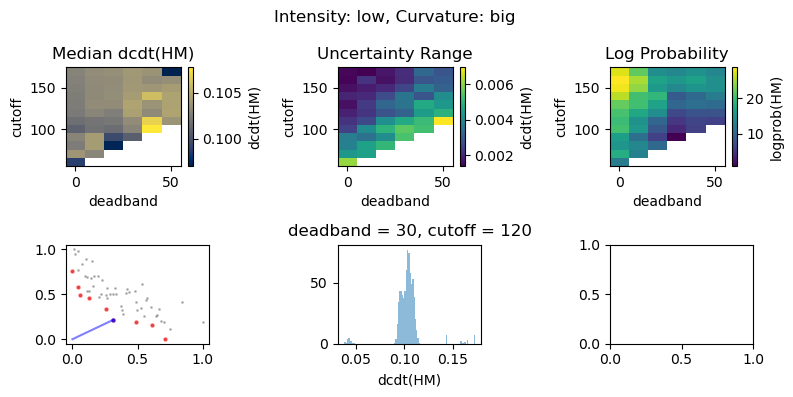

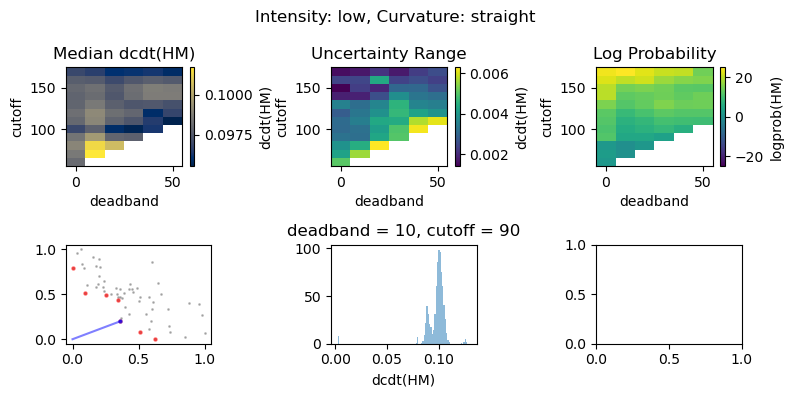

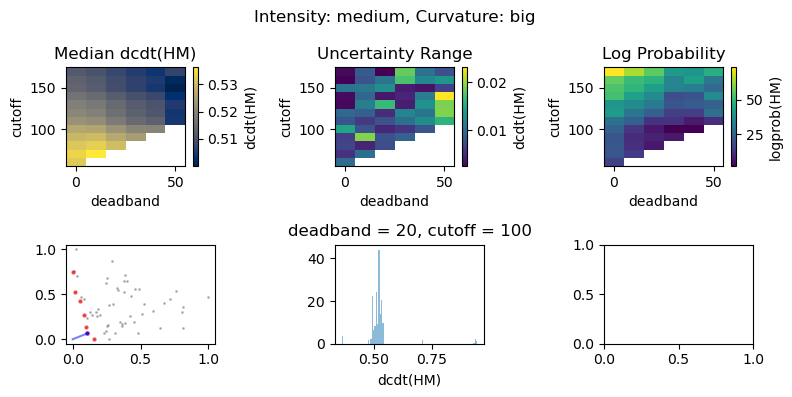

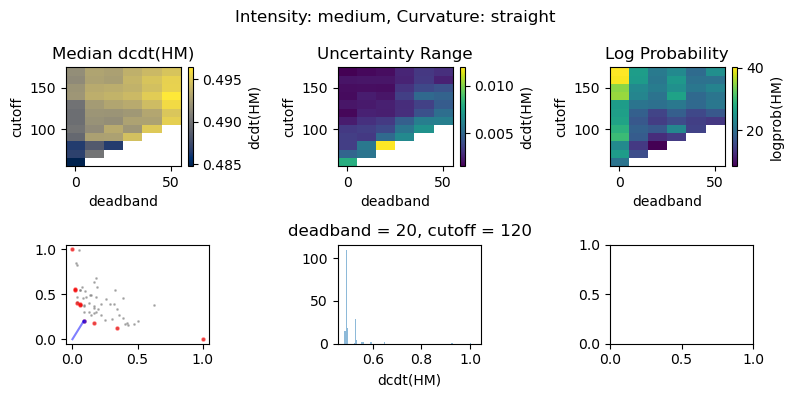

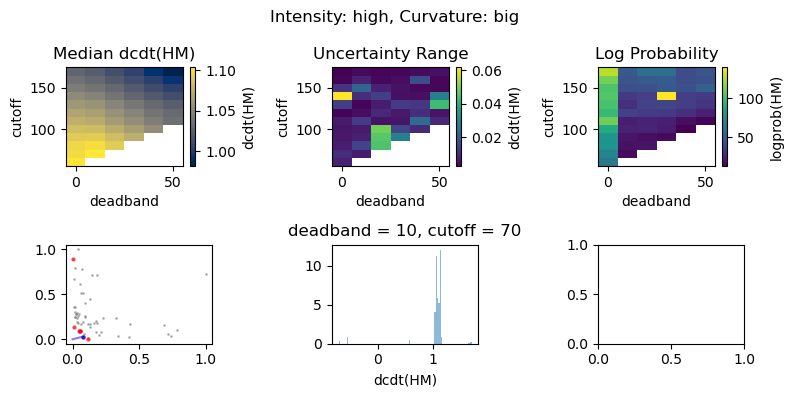

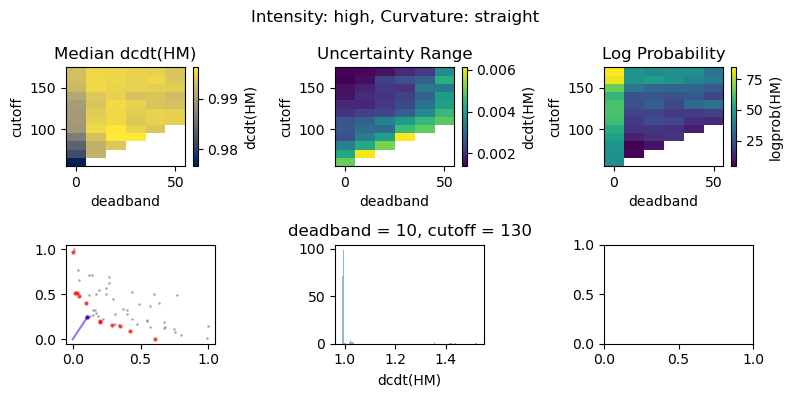

In [18]:
for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    for curve in np.unique(time_intensity['curvature'].values):
        time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values

        fig, ax = plt.subplots(2, 3, figsize=(8, 4))
        
        mc_hm = dsMC.sel(time=time_selection).median(dim=['MC','time'])['dcdt(HM)']

        pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection).median(dim=['time']))
        Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange, flatNorm_logprob = pa.prepare_metrics()
        pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                              y=flatNorm_logprob, 
                                                              maximize_x=False, maximize_y=False)
        coords_pareto_uncertaintyRange_logprob = pa.get_coords_pareto(pareto_indices=pareto_uncertaintyRange_logprob)

        best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob, 
                                                                  metric_x=Norm_uncertaintyRange,
                                                                  metric_y=Norm_logprob)
        uncertaintyRange_hm = pa.uncertaintyRange
        logprob_hm = pa.logprob

        hist_dcdt = dsMC.sel(time=time_selection,
                             deadband=deadband_coords[best_pareto_y].values,
                                cutoff=cutoff_coords[best_pareto_x].values)['dcdt(HM)']

    
        


        #### Plots ####
        ds.sel(time=time_selection)['dcdt(HM)'].median(dim='time').plot(ax=ax[0, 0], cmap='cividis')
        uncertaintyRange_hm.plot(ax=ax[0, 1], cmap='viridis')
        logprob_hm.plot(ax=ax[0, 2], cmap='viridis')

        ax[1,0].scatter(flatNorm_uncertaintyRange, flatNorm_logprob, s=1, c='gray', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob], 
                        Norm_logprob[coords_pareto_uncertaintyRange_logprob], 
                        s=5, c='red', alpha=0.5)
        ax[1,0].scatter(Norm_uncertaintyRange[best_pareto_x, best_pareto_y], 
                        Norm_logprob[best_pareto_x,best_pareto_y], s=5, c='blue', alpha=0.5)
        ax[1,0].plot([0, Norm_uncertaintyRange[best_pareto_x, best_pareto_y]], 
                     [0, Norm_logprob[best_pareto_x,best_pareto_y]], c='blue', alpha=0.5)
        
        # ax[1,1].hist(hist_dcdt, density=True, alpha=0.5)
        hist_dcdt.plot.hist(bins=100, density=True, alpha=0.5, ax=ax[1,1])

        fig.suptitle(f'Intensity: {intensity}, Curvature: {curve}')

        ax[0,0].set_title('Median dcdt(HM)')
        ax[0,1].set_title('Uncertainty Range')
        ax[0,2].set_title('Log Probability')
        fig.tight_layout()
        fig.show()
        # break